In [148]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np

import skimage

import torch
import torchvision
import pytorch_lightning

from torch.utils.data import Dataset, DataLoader

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [110]:
!ls -a '../input/amazon-forest1/Amazon Forest Dataset/Amazon Forest Dataset/Training'

.  ..  images  masks


### Configs

In [2]:
dataset_configs = {
    'data_path': '/kaggle/working'
}

### Dataset

#### Amazon forest 2

In [216]:
class AmazonForest2Dataset(Dataset):
    
    def __init__(self, root):
        
        self.img_files = []
        self.target_files = []
        for f in root.rglob('*.tif'):
            self.img_files.append(str(f))
            self.target_files.append(str(f).replace('image', 'label'))
            
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img = skimage.io.imread(self.img_files[idx])
        target = skimage.io.imread(self.target_files[idx])
        return img, target

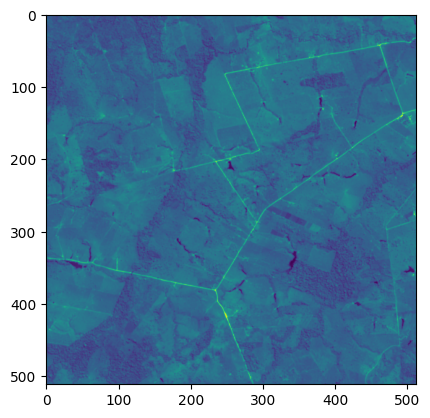

In [232]:
plt.imshow(amazon_forest2_dataset[0][0].mean(-1))

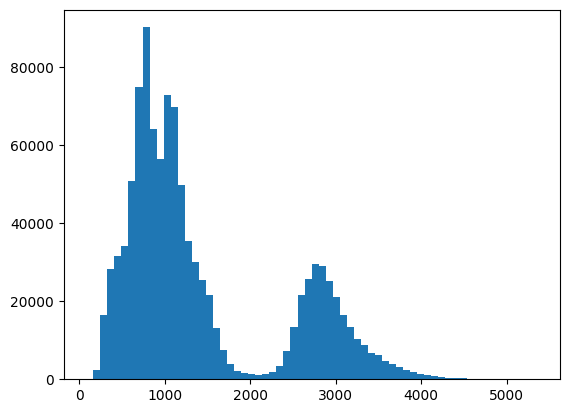

In [223]:
plt.hist(amazon_forest2_dataset[0][0].flatten(), bins=64);

In [217]:
amazon_forest2_dataset = AmazonForest2Dataset(root=pathlib.Path('../input/amazon-forest2/AMAZON/AMAZON/Training/image'))

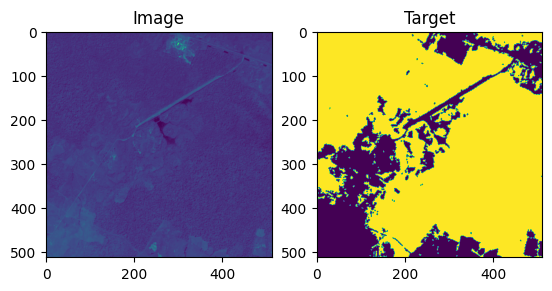

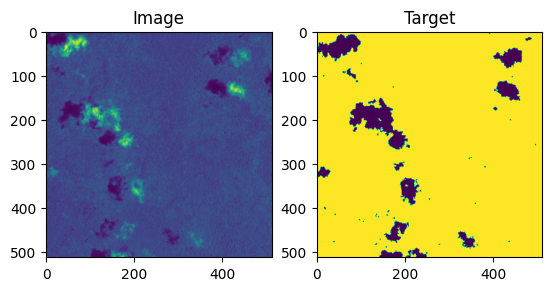

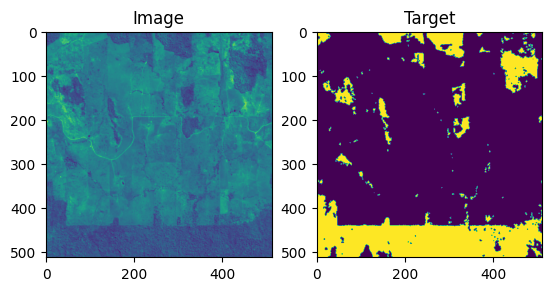

In [236]:
visualize_dataset(amazon_forest2_dataset, [1,11,111], visualize_amazon_forest2)

#### Amazon forest 1

In [176]:
class AmazonForest1Dataset(Dataset):
    
    def __init__(self, root):
        
        self.img_files = []
        self.target_files = []
        for f in root.rglob('*.tiff'):
            self.img_files.append(str(f))
            self.target_files.append(f"{str(f.parent / f.stem).replace('images', 'masks')}.png")
            
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img = skimage.io.imread(self.img_files[idx])
        target = torchvision.io.read_image(self.target_files[idx])
        return img, target

In [177]:
amazon_forest1_dataset = AmazonForest1Dataset(root=pathlib.Path('../input/amazon-forest1/Amazon Forest Dataset/Amazon Forest Dataset/Training'))

In [235]:
def visualize_dataset(dataset, inds, visualize_dataset_instance):
    for idx in inds:
        visualize_dataset_instance(dataset[idx])

def visualize_amazon_forest1(instance):
    img, target = instance
    plt.subplot(121)
    plt.title('Image')
    plt.imshow(img.squeeze())
    plt.subplot(122)
    plt.title('Target')
    plt.imshow(target.squeeze())
    plt.show()

    
def visualize_amazon_forest2(instance):
    img, target = instance
    plt.subplot(121)
    plt.title('Image')
    plt.imshow(img.squeeze().mean(-1))
    plt.subplot(122)
    plt.title('Target')
    plt.imshow(target.squeeze())
    plt.show()


In [182]:
len(amazon_forest_dataset)

30

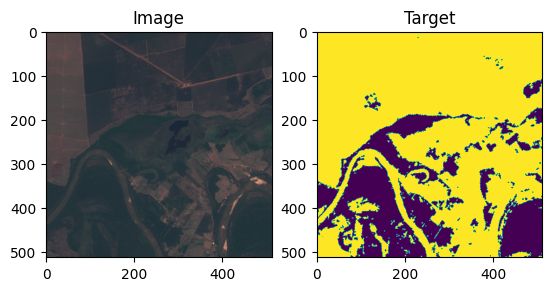

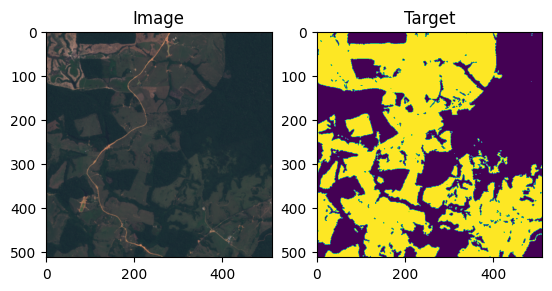

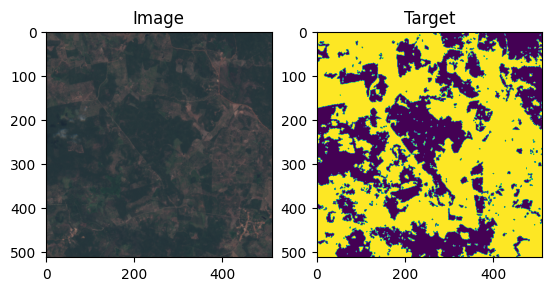

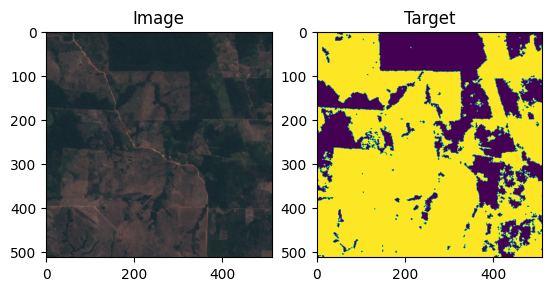

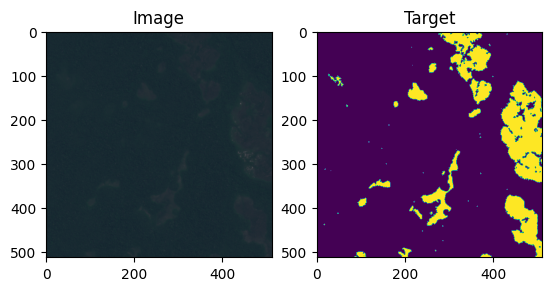

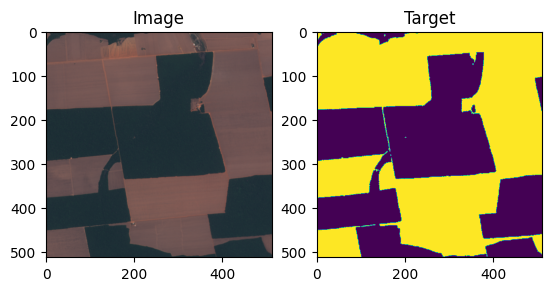

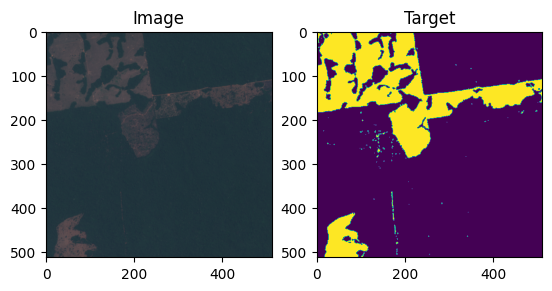

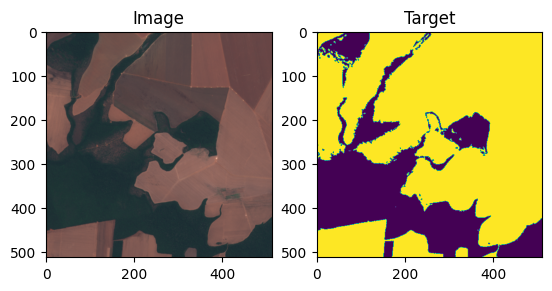

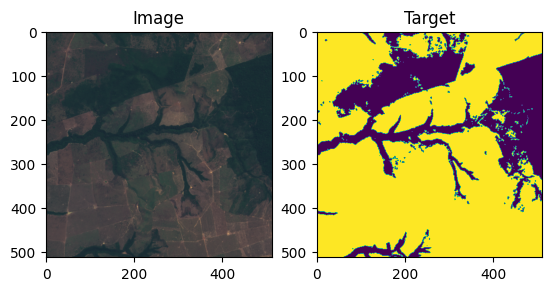

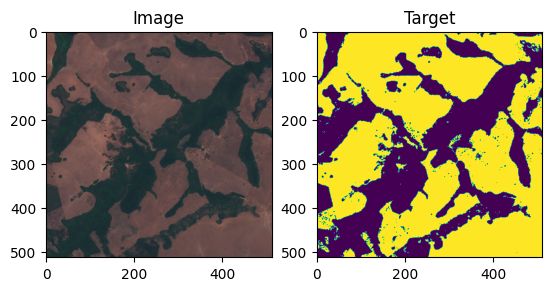

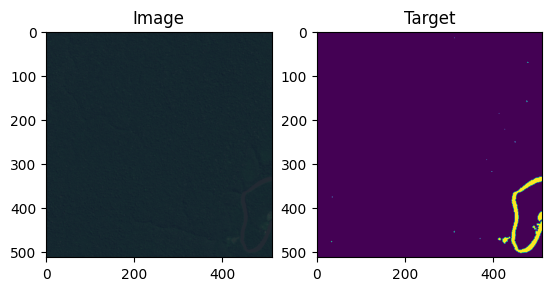

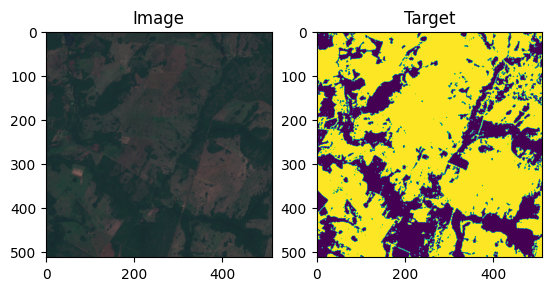

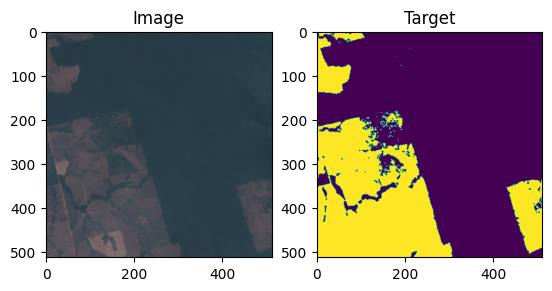

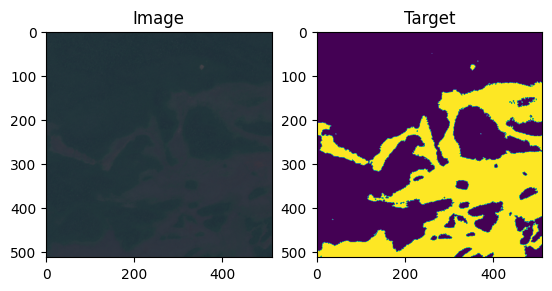

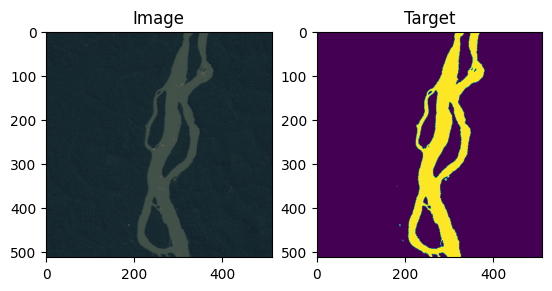

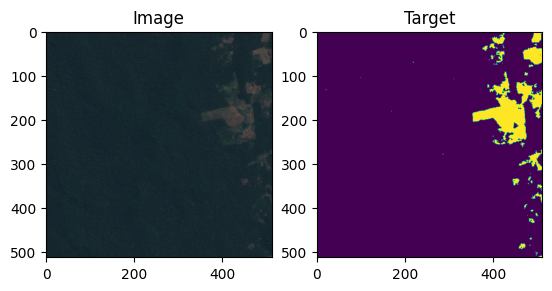

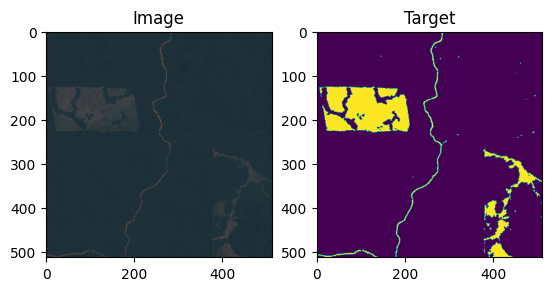

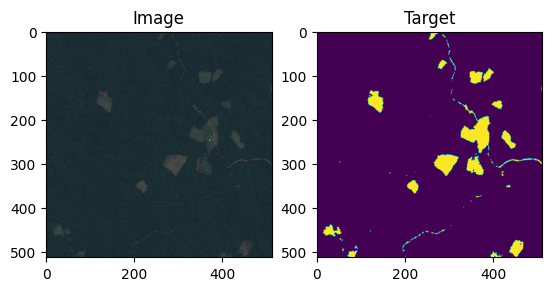

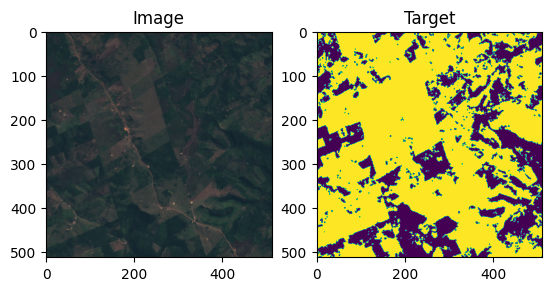

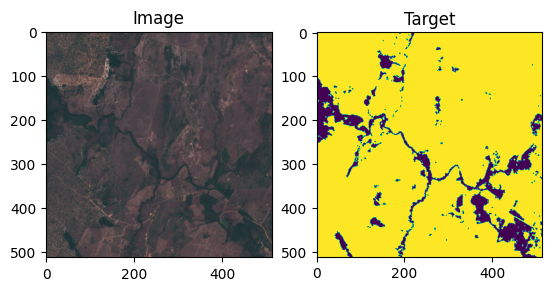

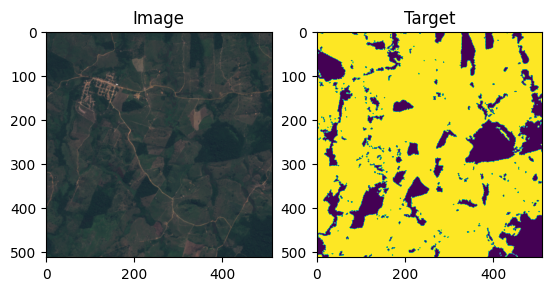

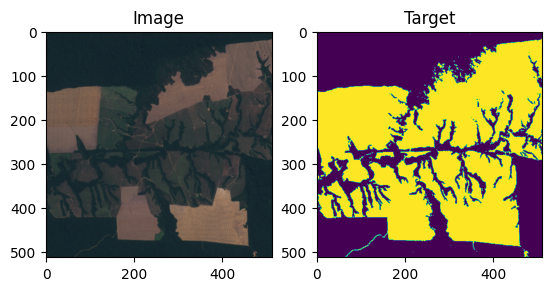

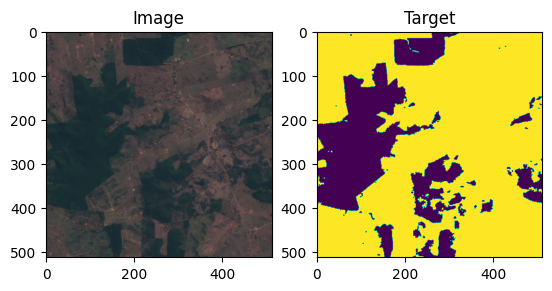

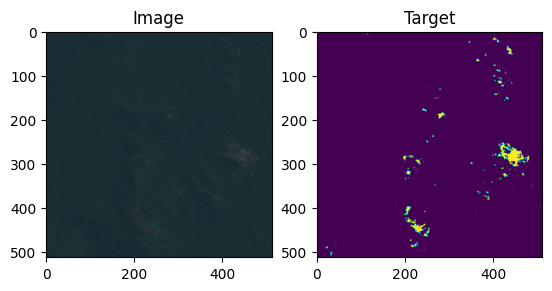

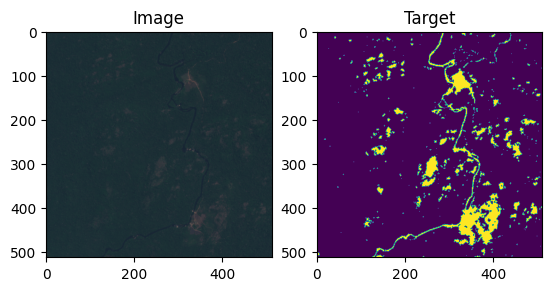

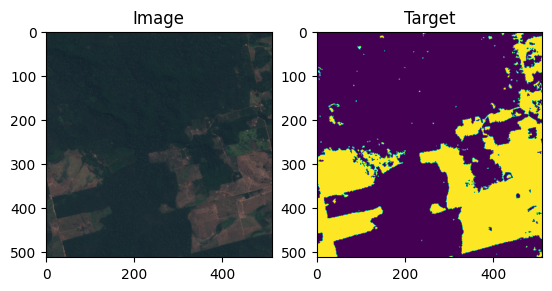

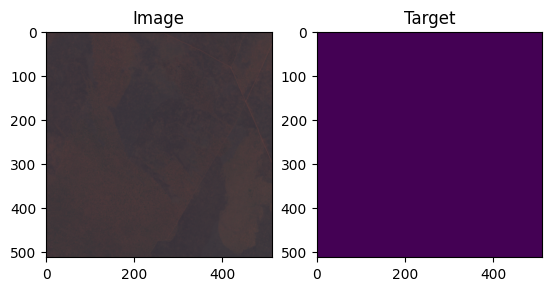

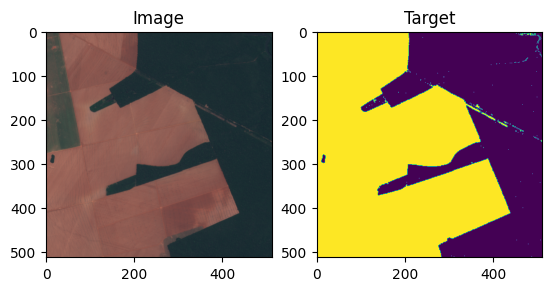

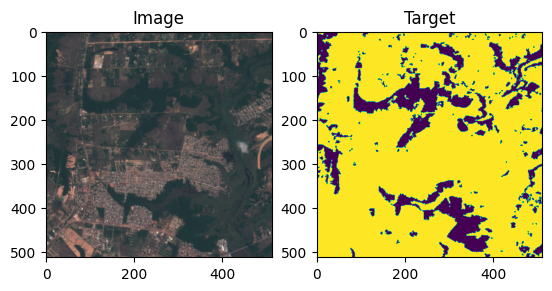

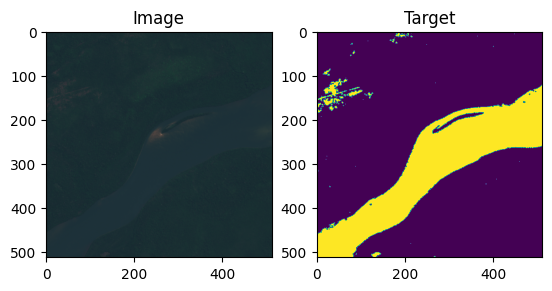

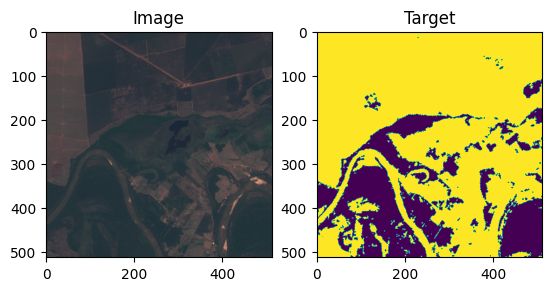

In [181]:
visualize_dataset(amazon_forest1_dataset, torch.arange(30), visualize_amazon_forest1)
visualize_amazon_forest1(amazon_forest_dataset[0])

In [172]:
amazon_forest_dataset.img_files[0], amazon_forest_dataset.target_files[0]

('../input/amazon-forest1/Amazon Forest Dataset/Amazon Forest Dataset/Training/images/Amazon_727.tiff_30.tiff',
 '../input/amazon-forest1/Amazon Forest Dataset/Amazon Forest Dataset/Training/masks/Amazon_727.tiff_30.png')

#### Eurosat

In [3]:
eurosat_ds = torchvision.datasets.EuroSAT(dataset_configs['data_path'],  download=True)

100%|██████████| 94280567/94280567 [00:05<00:00, 18685441.35it/s]


Extracting /kaggle/working/eurosat/EuroSAT.zip to /kaggle/working/eurosat


In [6]:
def visualize_eurosat_instance(instance, label_as_title=True):
    img, label = instance
    if label_as_title:
        plt.title(f'label: {label}')
    plt.imshow(img)
    plt.show()

def visualize_eurosat_by_label(dataset, label_to_visualize=0, n=32):
    c = 0
    for instance in dataset:
        img, label = instance
        if label == label_to_visualize:
            visualize_eurosat_instance(instance, label_as_title=False)
            c += 1
        if c >= n:
            break
            
def count_labels(dataset):
    label_counts = {}
    for img, label in dataset:
        count = label_counts.get(label, 0)
        label_counts[label] = count + 1
    return label_counts

def get_eurosat_by_label(dataset, label_to_return=0, n=32):
    c = 0
    images = []
    for instance in dataset:
        img, label = instance
        if label == label_to_return:
            images.append(img)
            c += 1
        if c >= n:
            return images

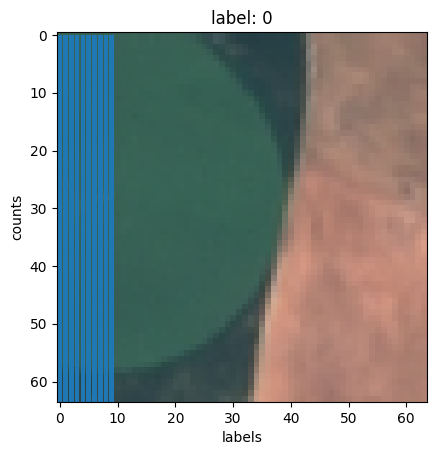

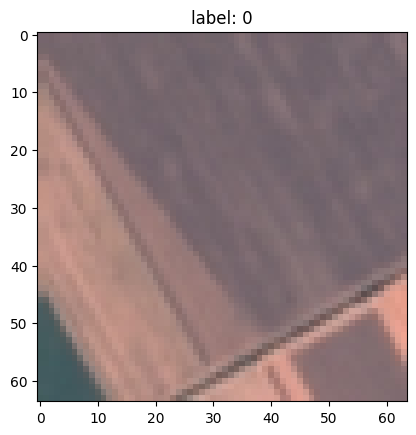

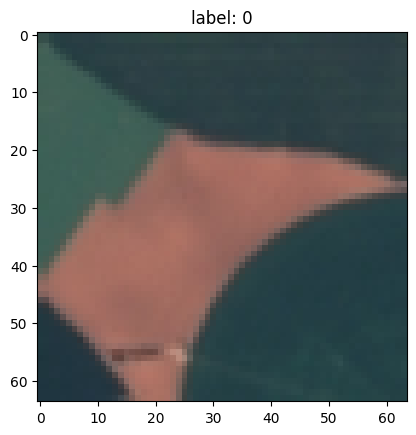

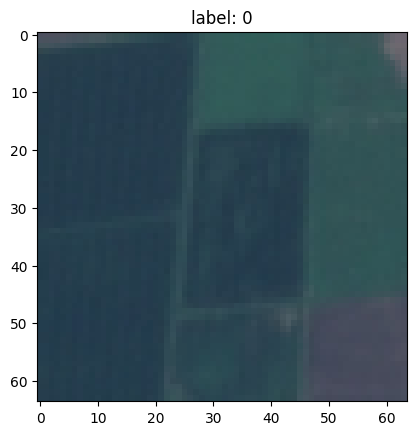

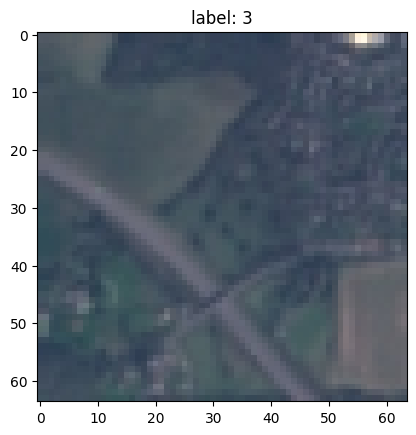

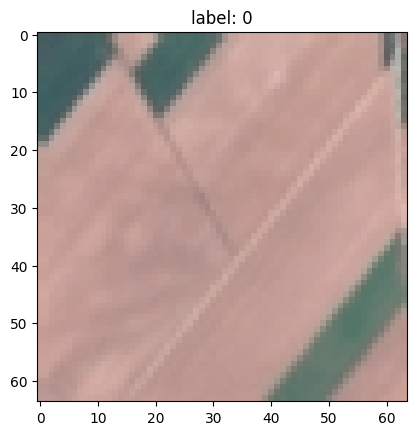

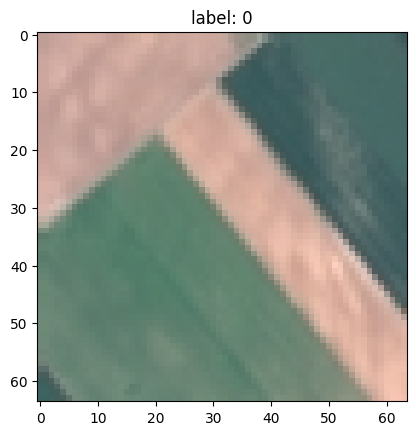

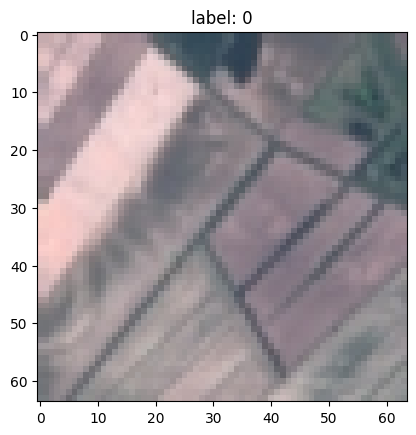

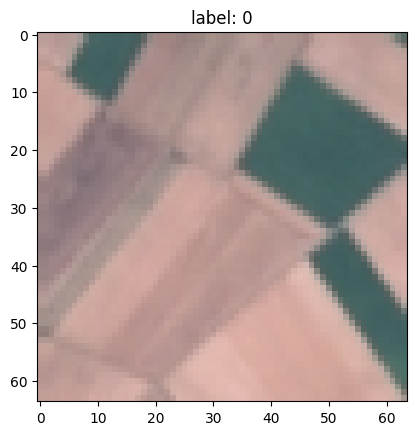

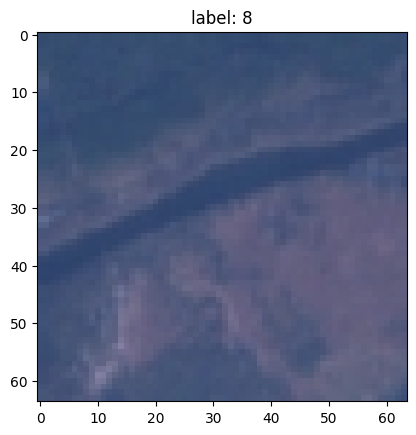

In [7]:
label_counts = count_labels(eurosat_ds)
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('labels')
plt.ylabel('counts')
plt.show

visualize_eurosat_by_label(eurosat_ds, label_to_visualize=11)

# 0 farmland
# 1 forest 
# 2 looks like river deltas or mountains
# 3 roads
# 4 houses
# 5 grassland
# 6 farmland?
# 7 cities / towns
# 8 rivers
# 9 water

visualize_eurosat(eurosat_ds, [1,11,111,1111,11111, 2, 22, 222, 2222, 22222])

### MMSegment

In [ ]:
# !pip install -U openmim
# !mim install mmengine
# !mim install "mmcv>=2.0.0"
# !pip install mmsegmentation

### Torchvision segmentation

In [9]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

n = 32
images = []
for idx, instance in enumerate(eurosat_ds):
    img, lable = instance
    images.append(transforms(img))

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

batch = torch.stack(images[:32])
output = model(batch)

for instance in output: 
    for name, entry in instance.items(): # ['boxes', 'labels', 'scores', 'masks']
        if name != 'masks':
            continue
        try:
            plt.title(name)
            plt.imshow(entry.detach().squeeze(), aspect='auto')
            plt.show()
        except Exception as e:
            print(name, entry.shape, e)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


### Superresolution

In [11]:
%%capture
!pip install git+https://github.com/huggingface/diffusers.git

In [12]:
from diffusers import LDMSuperResolutionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = LDMSuperResolutionPipeline.from_pretrained("CompVis/ldm-super-resolution-4x-openimages")
pipeline = pipeline.to(device)

low_res_img = get_eurosat_by_label(eurosat_ds, n=32, label_to_return=1)[-1]
low_res_img = low_res_img.resize((128, 128))

upscaled_img = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]

model_index.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.safetensors not found


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

vqvae/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/100 [00:00<?, ?it/s]

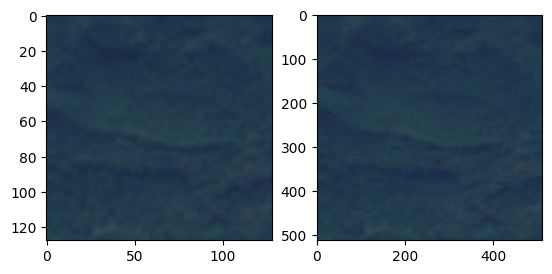

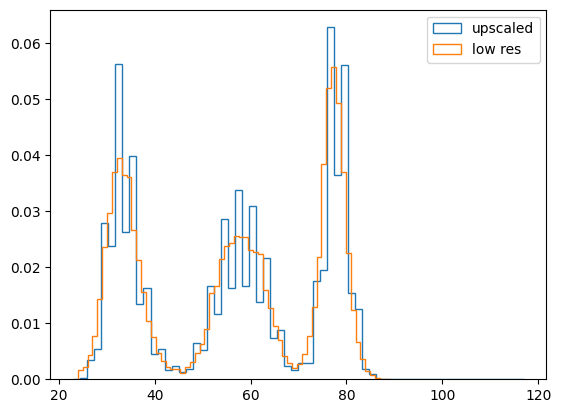

In [13]:
plt.subplot(121)
plt.imshow(low_res_img, aspect='auto')
plt.subplot(122)
plt.imshow(upscaled_img, aspect='auto')
plt.show()

plt.hist(np.asarray(upscaled_img).flatten(), histtype='step', label='upscaled', bins=64, density=True)
plt.hist(np.asarray(low_res_img).flatten(), histtype='step', label='low res', bins=64, density=True)
plt.legend()
plt.show()

### Segment anything

In [14]:
%%capture
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [79]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(upscaled_image)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth'

### Nvidia segformer

In [15]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

inputs = feature_extractor(images=upscaled_image, return_tensors="pt")
outputs = segformer(**inputs)
logits = outputs.logits.squeeze().detach()  # shape (batch_size, num_labels, height/4, width/4)


2024-04-27 00:37:59.899127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 00:37:59.899228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 00:38:00.042783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

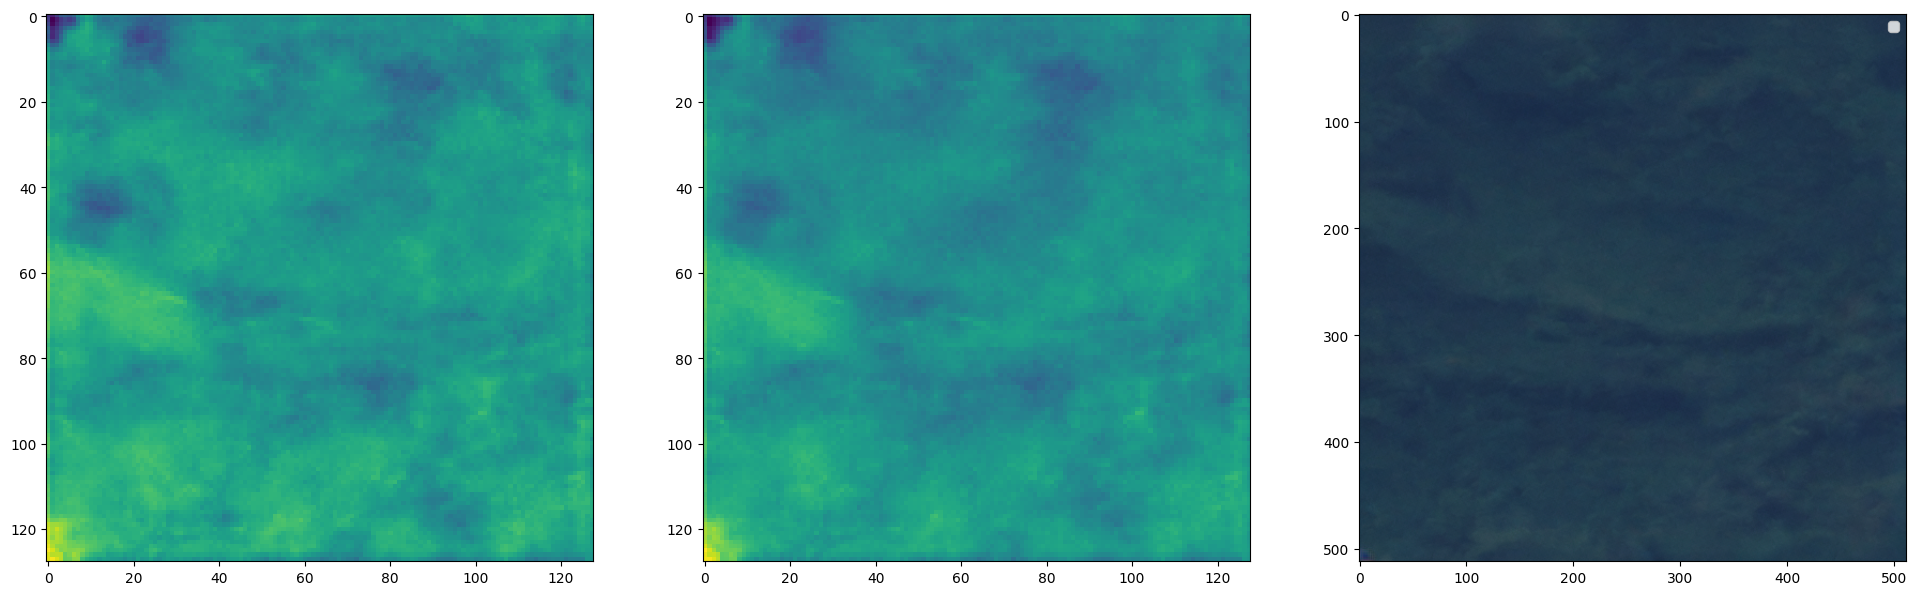

In [95]:
plt.figure(figsize=(24, 8))

plt.subplot(131)
plt.imshow(logits.min(0)[0], label='min segmentation')

plt.subplot(132)
plt.imshow(logits.mean(0), label='mean segmentation')

plt.subplot(133)
plt.imshow(upscaled_image, label='upscaled image')

plt.legend()
plt.show()

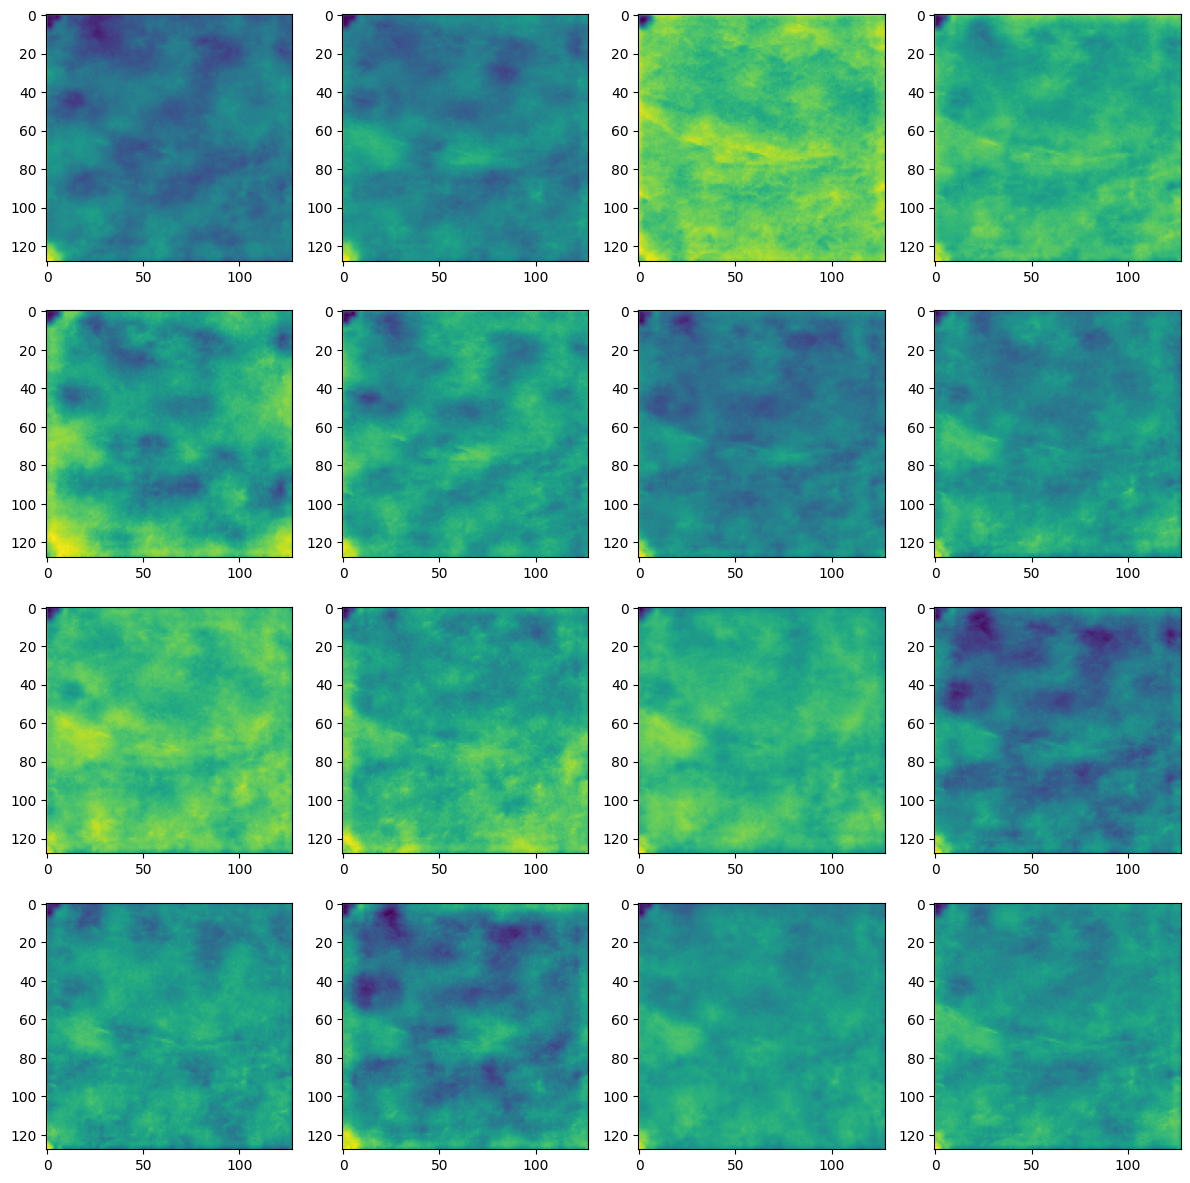

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
c = 0
for col_idx in range(axs.shape[0]):
    for row_idx in range(axs.shape[1]):
        axs[col_idx, row_idx].imshow(logits[c])
        c += 1
fig.tight_layout()
fig.show()

In [163]:
!pip install scipy
!pip install -U scikit-learn

10 0.025902431519528937 2
5 0.2633131058887652 6
2.5 26.765456751947664 109
1.25 0.0 1
1 0.0 1
0.5 0.0 1
0.1 0.0 1
0.01 0.0 1
0.001 0.0 1
0.0001 0.0 1
1e-05 0.0 1
1e-06 0.0 1
1e-07 0.0 1
1e-08 0.0 1


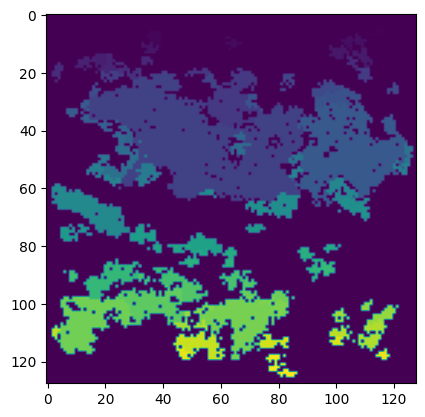

In [91]:
from sklearn.cluster import DBSCAN

for eps in [10, 5, 2.5, 1.25, 1, 5e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
    pixel_logits = logits.flatten(1).T
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(pixel_logits)
    print(eps, np.std(clusters), len(np.unique(clusters)))
    

pixel_logits = logits.flatten(1).T
dbscan = DBSCAN(eps=2.5, min_samples=10)
clusters = dbscan.fit_predict(pixel_logits)

plt.imshow(clusters.reshape(128, 128))
plt.show()